<a href="https://colab.research.google.com/github/juanigp/CT-denoising/blob/master/Training_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
!git clone -l -s git://github.com/juanigp/CT-denoising.git cloned-repo
%cd cloned-repo
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd
import numpy as np
!pip install SimpleITK
import SimpleITK as sitk
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch
import random
import os
import utils.ReadWriteXML as rw
from utils import utils
from models.EDCNN import EDCNN

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
Cloning into 'cloned-repo'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 273 (delta 0), reused 0 (delta 0), pack-reused 270
Receiving objects: 100% (273/273), 41.30 MiB | 24.98 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/cloned-repo
     |████████████████████████████████| 42.5MB 81kB/s 


Text(0.5, 0.98, 'Loss vs epochs: 100 mAs - 250 mAs - 360 mAs')

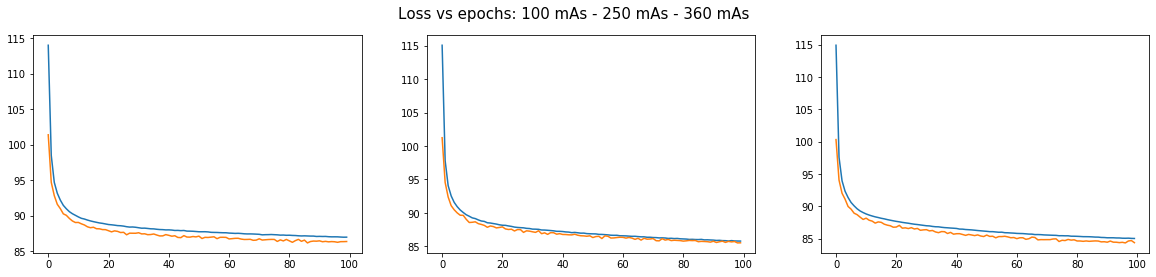

In [0]:
loss_100 = r'/gdrive/My Drive/models/training_loss.csv' 
df_100 = pd.read_csv(loss_100, names=['train loss', 'test loss'])
loss_250 = r'/gdrive/My Drive/models/training_loss_250.csv' 
df_250 = pd.read_csv(loss_250, names=['train loss', 'test loss'])
loss_360 = r'/gdrive/My Drive/models/training_loss_360.csv' 
df_360 = pd.read_csv(loss_360, names=['train loss', 'test loss'])

fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1, 3, 1)
plt.plot( df_100['train loss'].values )
plt.plot( df_100['test loss'].values )
fig.add_subplot(1, 3, 2)
plt.plot( df_250['train loss'].values )
plt.plot( df_250['test loss'].values )
fig.add_subplot(1, 3, 3)
plt.plot( df_360['train loss'].values )
plt.plot( df_360['test loss'].values )
plt.suptitle('Loss vs epochs: 100 mAs - 250 mAs - 360 mAs', fontsize = 15)

### The training loss was calculated during the execution of the epochs, meanwhile the test loss was calculated after a training epoch, with fixed network parameters.

In [2]:
lr_dir = r'/gdrive/My Drive/volumes/calib'
gt_dir = r'/gdrive/My Drive/volumes/XCT'

checkpoint_100_dir = r'/gdrive/My Drive/models/EDCNN_checkpoint_epoch_100.pth.tar'
checkpoint_250_dir = r'/gdrive/My Drive/models/EDCNN_250_checkpoint_epoch_100.pth.tar'
checkpoint_360_dir = r'/gdrive/My Drive/models/EDCNN_360_checkpoint_epoch_100.pth.tar'

checkpoint_100 = torch.load(checkpoint_100_dir)
checkpoint_250 = torch.load(checkpoint_250_dir)
checkpoint_360 = torch.load(checkpoint_360_dir)

model_100 = EDCNN()
model_250 = EDCNN()
model_360 = EDCNN()

model_100.load_state_dict(checkpoint_100['model'])
model_250.load_state_dict(checkpoint_250['model'])
model_360.load_state_dict(checkpoint_360['model'])

model_100.cuda()
model_250.cuda()
model_360.cuda()

model_100.eval()
model_250.eval()
model_360.eval()

EDCNN(
  (enc_1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_2): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_3): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_4): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_1): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_2): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_3): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_4): ConvTranspose3d(32, 1, kernel_size=(3, 5, 5), stride=(1, 1, 1))
)

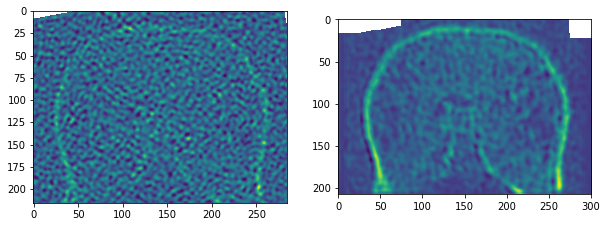

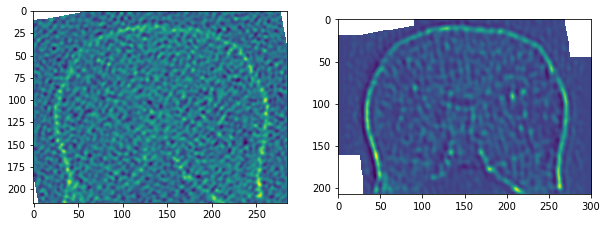

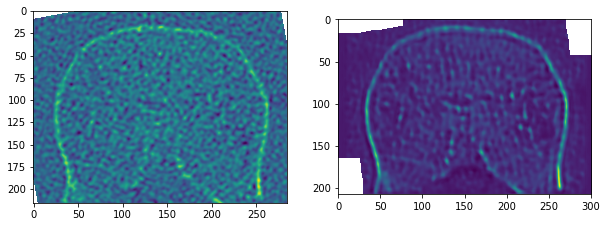

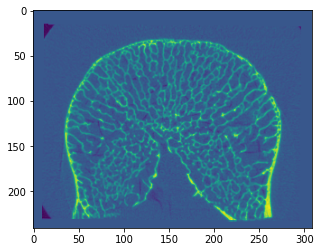

In [3]:
#opening input volume
target_volume_ = rw.OpenXML(os.path.join(gt_dir, '5a_XCTSlices.xml'), kind = 'Slices' )
target_volume = sitk.GetArrayFromImage(target_volume_)

volumes_nets = [('5a_100_FBPPhil_Scan1Slices.xml', model_100 ),
                ('5a_250_FBPPhil_Scan1Slices.xml', model_250 ),
                ('5a_360_FBPPhil_Scan1Slices.xml', model_360) ]
count = 0
for volume, model in volumes_nets:
  input_volume_ = rw.OpenXML(os.path.join(lr_dir, volume), kind = 'Slices' )
  input_volume = sitk.GetArrayFromImage(input_volume_)[46:55,:,:]

  z, x, y = input_volume.shape
  padded = np.zeros((z,x+16,y+16))
  padded[:,8:x+8, 8:y+8] = input_volume
  input_volume_tensor = torch.from_numpy(padded)
  input_volume_tensor = input_volume_tensor.unsqueeze(0).unsqueeze(0)
  input_volume_tensor = utils.var_or_cuda( input_volume_tensor )
  input_volume_tensor = input_volume_tensor.type(torch.FloatTensor).cuda()
  net_output = model(input_volume_tensor)
  output_cpu_ = net_output.detach()
  output_cpu_ = output_cpu_.cpu()
  output_cpu = output_cpu_[0][0][:][:][:]

  fig = plt.figure(count, figsize=(10, 5))
  a = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(input_volume[4][:][:])
  a = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(output_cpu[4][8:x+8][8:y+8])
  count += 1

fig = plt.figure(count, figsize=(7, 4))
imgplot = plt.imshow(target_volume[50][:][:])

In [0]:
csvs_100 = (r'/gdrive/My Drive/patches/100_FBPPhil.csv',
            r'/gdrive/My Drive/patches/100_FBPPhil_bm4d.csv')

csvs_250 = (r'/gdrive/My Drive/patches/250_FBPPhil.csv',
            r'/gdrive/My Drive/patches/250_FBPPhil_bm4d.csv')

csvs_360 = (r'/gdrive/My Drive/patches/360_FBPPhil.csv',
            r'/gdrive/My Drive/patches/360_FBPPhil_bm4d.csv')

csvs_list = [csvs_100, csvs_250, csvs_360]
dataloader_list = []
batch_size = 32
for csv_tuple in csvs_list:
  dataset_lr = utils.CTVolumesDataset( csv_tuple[0] )
  dataset_bm4d = utils.CTVolumesDataset( csv_tuple[1] )
  num_samples = len(dataset_bm4d)
  total_idx = list(range(num_samples))
  random.seed(10)
  random.shuffle(total_idx)
  #pick 10% of samples to test
  testing_samples_percentage = 0.1
  split_index = int( num_samples * testing_samples_percentage )
  #pick the first 10% of samples in the shuffled dataset for testing
  testing_idx = total_idx[0 : split_index]
  testing_sampler = sampler.SubsetRandomSampler(testing_idx)
  dataloader_lr = torch.utils.data.DataLoader(dataset = dataset_lr, batch_size = batch_size, sampler = testing_sampler)
  dataloader_bm4d = torch.utils.data.DataLoader(dataset = dataset_bm4d, batch_size = batch_size, sampler = testing_sampler)
  dataloader_tuple = (dataloader_lr, dataloader_bm4d)
  dataloader_list.append(dataloader_tuple)

models_list = [model_100, model_250, model_360]

#computation of standard deviation of dataset, used in psnr calculation
dataloader = dataloader_list[0][0]
z,x,y = dataloader.dataset[0][1].shape
hi_res_tensors = torch.Tensor(0,z,x,y)
for i, (lo_res, hi_res)in enumerate(dataloader):
  hi_res_tensors = torch.cat((hi_res, hi_res_tensors), 0)
std = float(hi_res_tensors.std())

#loss functions init
MSE = nn.MSELoss()
MSE.cuda()

L1 = nn.L1Loss()
L1.cuda()

losses_list = []
for (dataloader_lr, dataloader_bm4d) in dataloader_list:
  lr_rmse = 0
  lr_mae = 0
  lr_snr = 0
  lr_ssim = 0

  nn_rmse = 0
  nn_mae = 0
  nn_psnr = 0
  nn_ssim = 0

  bm4d_rmse = 0
  bm4d_mae = 0
  bm4d_psnr = 0
  bm4d_ssim = 0

  model = models_list[len(losses_list)]
  num_batches = 0
  
  for i, (lo_res, hi_res) in enumerate(dataloader_lr):
    #add an extra dimension:
    lo_res = lo_res.cuda()
    hi_res = hi_res.cuda()
    if lo_res.size()[0] != batch_size:
      continue
    nn_out = model( lo_res.unsqueeze(1) ).squeeze()
    nn_out_np = nn_out.cpu().detach().numpy()
    lo_res_np = lo_res.cpu().detach().numpy()
    hi_res_np = hi_res.cpu().detach().numpy()
    nn_rmse += MSE( nn_out, hi_res ).item()
    nn_mae += L1( nn_out, hi_res ).item()
    #nn_snr_ = torch.sum( nn_out**2 )/torch.sum( (nn_out - hi_res)**2 )
    nn_psnr += psnr(hi_res_np, nn_out_np, data_range = 6 * std)#nn_snr += nn_snr_.item()
    nn_ssim += ssim(hi_res_np, nn_out_np, multichannel = True)

    lr_rmse += MSE( lo_res, hi_res ).item()
    lr_mae += L1( lo_res, hi_res ).item()
    #lr_snr_ = torch.sum( lo_res**2 )/torch.sum( (lo_res - hi_res)**2 )
    lr_psnr += psnr(hi_res_np, lo_res_np, data_range = 6 * std)#lr_snr_.item()
    lr_ssim += ssim(hi_res_np, lo_res_np, multichannel = True)

    num_batches += 1 

  for i, (lo_res_bm4d, hi_res) in enumerate(dataloader_bm4d):
    #add an extra dimension:
    lo_res_bm4d = lo_res_bm4d.cuda()
    hi_res = hi_res.cuda()
    if lo_res_bm4d.size()[0] != batch_size:
      continue  
    lo_res_bm4d_np = lo_res_bm4d.cpu().detach().numpy()
    hi_res_np = hi_res.cpu().detach().numpy()

    bm4d_rmse += MSE( lo_res_bm4d, hi_res ).item()
    bm4d_mae += L1( lo_res_bm4d, hi_res ).item()
    #bm4d_snr_ = torch.sum( lo_res_bm4d**2 )/torch.sum( (lo_res_bm4d - hi_res)**2 )
    bm4d_psnr += psnr(hi_res_np, lo_res_bm4d_np, data_range = 6 * std)#bm4d_snr_.item()
    bm4d_ssim += ssim(hi_res_np, lo_res_bm4d_np, multichannel = True)

  nn_rmse = np.sqrt( nn_rmse / num_batches )
  nn_mae /= num_batches 
  nn_psnr /= num_batches
  nn_ssim /= num_batches

  lr_rmse = np.sqrt( lr_rmse / num_batches )
  lr_mae /= num_batches
  lr_psnr /= num_batches
  lr_ssim /= num_batches
  
  bm4d_rmse = np.sqrt( bm4d_rmse / num_batches )
  bm4d_mae /= num_batches
  bm4d_psnr /= num_batches
  bm4d_ssim /= num_batches

  mae_losses = (lr_mae, bm4d_mae, nn_mae)
  rmse_losses = (lr_rmse, bm4d_rmse, nn_rmse)
  psnr_losses = (lr_psnr, bm4d_psnr, nn_psnr)
  ssim_losses = (lr_ssim, bm4d_ssim, nn_ssim)

  losses_dict =	{
    "mae": mae_losses,
    "rmse": rmse_losses,
    "psnr": psnr_losses,
    "ssim": ssim_losses
  }
  losses_list.append(losses_dict)




### RMSE, MAE, SNR, SSIM comparissons: Lo res volume vs BM4D filter vs EDCNN

In [70]:
print('100 mAs:')
print('RMSE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[0]['rmse'][0], losses_list[0]['rmse'][1], losses_list[0]['rmse'][2]))
print('MAE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[0]['mae'][0], losses_list[0]['mae'][1], losses_list[0]['mae'][2]))
print('SNR')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(10*np.log(losses_list[0]['psnr'][0]), 10*np.log(losses_list[0]['psnr'][1]), 10*np.log(losses_list[0]['psnr'][2])))
print('SSIM')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[0]['ssim'][0], losses_list[0]['ssim'][1], losses_list[0]['ssim'][2]))
print('\n')

print('250 mAs:')
print('RMSE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[1]['rmse'][0], losses_list[1]['rmse'][1], losses_list[1]['rmse'][2]))
print('MAE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[1]['mae'][0], losses_list[1]['mae'][1], losses_list[1]['mae'][2]))
print('SNR')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(10*np.log(losses_list[1]['psnr'][0]), 10*np.log(losses_list[1]['psnr'][1]), 10*np.log(losses_list[1]['psnr'][2])))
print('SSIM')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[1]['ssim'][0], losses_list[1]['ssim'][1], losses_list[1]['ssim'][2]))
print('\n')

print('360 mAs:')
print('RMSE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[2]['rmse'][0], losses_list[2]['rmse'][1], losses_list[2]['rmse'][2]))
print('MAE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[2]['mae'][0], losses_list[2]['mae'][1], losses_list[2]['mae'][2]))
print('SNR')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(10*np.log(losses_list[2]['psnr'][0]), 10*np.log(losses_list[2]['psnr'][1]), 10*np.log(losses_list[2]['psnr'][2])))
print('SSIM')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[2]['ssim'][0], losses_list[2]['ssim'][1], losses_list[2]['ssim'][2]))

100 mAs:
RMSE
lo res: 339.84616416262907, bm4d: 322.81575411056644, EDCNN: 124.79518582303271
MAE
lo res: 271.24809345446135, bm4d: 257.6963468852796, EDCNN: 85.77815768593236
SNR
lo res: 19.83085823059082, bm4d: 20.42762565612793, EDCNN: 27.70941925048828
SSIM
lo res: 0.08179162409087733, bm4d: 0.09351335685249136, EDCNN: 0.17510683838243563


250 mAs:
RMSE
lo res: 230.65235761642057, bm4d: 220.4826540572559, EDCNN: 123.99064354821294
MAE
lo res: 183.08861421283922, bm4d: 175.02351540013365, EDCNN: 85.06869346217105
SNR
lo res: 23.638511657714844, bm4d: 24.000246047973633, EDCNN: 27.74451446533203
SSIM
lo res: 0.17921325347648245, bm4d: 0.19350395791441163, EDCNN: 0.20705135934808264


360 mAs:
RMSE
lo res: 200.1619086621536, bm4d: 192.80027524583159, EDCNN: 121.97312640482372
MAE
lo res: 158.7676335384971, bm4d: 152.8399079975329, EDCNN: 83.97898904900802
SNR
lo res: 24.735130310058594, bm4d: 25.004440307617188, EDCNN: 27.831077575683594
SSIM
lo res: 0.2264715959564605, bm4d: 0.23958